<a href="https://colab.research.google.com/github/thetishadas/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install my_utils


In [3]:
# user definded function to indicate processing progress
import my_utils

import html
import time
import functools
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords as sw
import string
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import pickle

In [9]:
data = pd.read_csv("/content/preprocessed_kindle_review .csv")

In [10]:
data.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [13]:
data.tail()

,Unnamed: 0,rating,reviewText,summary
11995,11995,2,Had to read certain passages twice--typos. Wi...,Where's the meat?
11996,11996,3,Not what i expected. yet a very interesting bo...,Interesting
11997,11997,5,Dragon Knights is a world where Knights ride d...,"Dragon Knights, Wings of Change (I Dream of Dr..."
11998,11998,4,"Since this story is very short, it's hard to s...","Good writing, short story"
11999,11999,4,from 1922 an amazing collection of info on sym...,interesting public domain book


In [11]:
data.columns.values

array(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype=object)

In [14]:
# Make a new column named 'pos_neg', which has value 'neg' if the overall rating is 1, 2 ,or 3,
# and has value 'pos' of the overall rating is 4 or 5.

# Assuming the rating column is named 'rating', replace 'overall' with 'rating'
data.loc[data['rating'].isin([1,2,3]), 'pos_neg'] = 'neg'
data.loc[data['rating'].isin([4,5]), 'pos_neg'] = 'pos'

In [15]:
# Choose only the columns 'pop_neg' and 'reviewText'
df = data[['pos_neg', 'reviewText']]

In [16]:
df.head()

,pos_neg,reviewText
0,pos,This book was the very first bookmobile book I...
1,neg,"When I read the description for this book, I c..."
2,pos,I just had to edit this review. This book is a...
3,pos,I don't normally buy 'mystery' novels because ...
4,pos,"This isn't the kind of book I normally read, a..."


In [17]:
data.shape

(12000, 5)

In [18]:
# Check the distribution of the positive and negative reviews
df.pos_neg.value_counts()

,count
pos_neg,
pos,6000
neg,6000


In [19]:
# Sample positive reveiws to get a balanced dataset
neg = df.loc[df.pos_neg=='neg']
pos = df.loc[df.pos_neg=='pos'].sample(n=df.pos_neg.value_counts()['neg'], random_state=42)

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
lemmatizer = nltk.WordNetLemmatizer()
stopwords = sw.words('english')
stopwords = stopwords + ['not_' + w for w in stopwords]

# transform punctuation to blanks
trans_punct = str.maketrans(string.punctuation,' '*len(string.punctuation))

# pad punctuation with blanks
pad_punct = str.maketrans({key: " {0} ".format(key) for key in string.punctuation})
# remove "_" from string.punctuation
invalidChars = str(string.punctuation.replace("_", ""))

In [22]:
def preprocessing(line, ngram=1, neg_handling=True, remove_stop=False):
    """
    Preprocessing the review texts
    @params:
        line                       - Required: the input text (Str)
        ngram                  - Optional: number n in the n-gram model(Int, 1, 2, or 3)
        neg_handling       - Optional: whether to perform negation handling (Boolean)
        remove_stop        -Optional: whether to remove the stop words (Boolean)
    """

    line = html.unescape(str(line))
    line = str(line).replace("can't", "can not")
    line = str(line).replace("n't", " not")

    if neg_handling:
        line = str(line).translate(pad_punct)  # If performing negation handling, pad punctuations with blanks
        line = nltk.word_tokenize(line.lower()) # Word normalization and tokenization
        tokens = []
        negated = False
        for t in line:
            if t in ['not', 'no']:
                negated = not negated
            elif t in string.punctuation or not t.isalpha():
                negated = False
            else:
                tokens.append('not_' + t if negated else t)  # add "not_" prefix to words behind "not", or "no"
    else:
        line = str(line).translate(trans_punct)  # If not performing negation handling, remove punctuations
        line = nltk.word_tokenize(line.lower()) # Word normalization and tokenization
        tokens = line

    if ngram==2:
        bi_tokens = list(nltk.bigrams(line))
        bi_tokens = list(map('_'.join, bi_tokens))
        bi_tokens = [i for i in bi_tokens if all(j not in invalidChars for j in i)]
        tokens = tokens + bi_tokens

    if ngram==3:
        bi_tokens = list(nltk.bigrams(line))
        bi_tokens = list(map('_'.join, bi_tokens))
        bi_tokens = [i for i in bi_tokens if all(j not in invalidChars for j in i)]
        tri_tokens = list(nltk.trigrams(line))
        tri_tokens = list(map('_'.join, tri_tokens))
        tri_tokens = [i for i in tri_tokens if all(j not in invalidChars for j in i)]
        tokens = tokens + bi_tokens + tri_tokens

    if remove_stop:
        line = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
    else:
        line = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(line)

In [23]:
line = "I don't think this book has any decent information!!! It is full of typos and factual errors that I can't ignore."

In [24]:
!pip install nltk
import nltk
import html
import string
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # Download the missing 'wordnet' dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [25]:
preprocessing(line, ngram=1, neg_handling=False, remove_stop=False)

'i do not think this book ha any decent information it is full of typo and factual error that i can not ignore'

In [26]:
preprocessing(line, ngram=1, neg_handling=False, remove_stop=True)

'think book decent information full typo factual error ignore'

In [27]:
preprocessing(line, ngram=1, neg_handling=True, remove_stop=False)

'i do not_think not_this not_book not_has not_any not_decent not_information it is full of typo and factual error that i can not_ignore'

In [28]:
preprocessing(line, ngram=3, neg_handling=True, remove_stop=False)

'i do not_think not_this not_book not_has not_any not_decent not_information it is full of typo and factual error that i can not_ignore i_do do_not not_think think_this this_book book_has has_any any_decent decent_information it_is is_full full_of of_typos typos_and and_factual factual_errors errors_that that_i i_can can_not not_ignore i_do_not do_not_think not_think_this think_this_book this_book_has book_has_any has_any_decent any_decent_information it_is_full is_full_of full_of_typos of_typos_and typos_and_factual and_factual_errors factual_errors_that errors_that_i that_i_can i_can_not can_not_ignore'

In [29]:
def print_progress(bar_length=50, decimals=0, iteration=1, total=100, prefix='', suffix='', fill='█', printEnd="\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(bar_length * iteration // total)
    bar = fill * filledLength + '-' * (bar_length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    if iteration == total:
        print()

In [30]:
# Preprocessing the positive reveiws
pos_data = []
n_pos = len(pos)
for i, p in enumerate(pos['reviewText']):
    pos_data.append(preprocessing(p, ngram=3))
    # Using the print_progress function defined above
    print_progress(bar_length=50, decimals=0, iteration=i+1, total=n_pos, prefix='Preprocessing pos data: ')

Preprocessing pos data:  |██████████████████████████████████████████████████| 100% 


In [31]:
# Preprocessing the positive reveiws
neg_data = []
n_neg = len(neg)
for i, p in enumerate(neg['reviewText']):
    pos_data.append(preprocessing(p, ngram=3))
    # Using the print_progress function defined above
    print_progress(bar_length=50, decimals=0, iteration=i+1, total=n_neg, prefix='Preprocessing neg data: ')

Preprocessing neg data:  |██████████████████████████████████████████████████| 100% 


In [32]:
# Combine the preprocessed data
data = pos_data + neg_data
labels = np.concatenate((pos['pos_neg'].values, neg['pos_neg'].values))

In [33]:
# split the dataset to training, validation, test sets by 60-20-20
train_data, rest_data, train_labels, rest_labels = train_test_split(data, labels, test_size=0.4,
                                                                    stratify=labels, random_state=1234)
valid_data, test_data, valid_labels, test_labels = train_test_split(rest_data, rest_labels, test_size=0.5,
                                                                    stratify=rest_labels, random_state=1234)
print("training size = ", len(train_data), "validation size = ", len(valid_data), "testing size = ", len(test_data))

training size =  7200 validation size =  2400 testing size =  2400


In [34]:
# Push all tokens and compute the frequency of words
tokens = [word for line in train_data for word in nltk.word_tokenize(line)]
word_features = nltk.FreqDist(tokens)

In [35]:
print(word_features)

<FreqDist with 622006 samples and 2100279 outcomes>


In [36]:
# Print the 10 most common words
word_features.most_common(10)

[('the', 36073),
 ('a', 24085),
 ('and', 22225),
 ('i', 21293),
 ('to', 18677),
 ('of', 14618),
 ('it', 12967),
 ('is', 12013),
 ('this', 10571),
 ('wa', 10456)]

In [37]:
# Remove features (words) which occur only once (This is to be used in the basic modeling process)
topwords = [fpair[0] for fpair in list(word_features.most_common(len(word_features))) if fpair[1]>=2]
len(topwords)

130695

In [38]:
# 3.2 Vectorizer and Tf–idf term weighting
# Convert a collection of raw documents to a matrix of TF-IDF features.
# Equivalent to CountVectorizer followed by TfidfTransformer.
tf_vec = TfidfVectorizer()

tf_vec.fit_transform([' '.join(topwords)])

<1x130663 sparse matrix of type '<class 'numpy.float64'>'
	with 130663 stored elements in Compressed Sparse Row format>

In [39]:
# Extract features from training set
# Vocabulary is from topwords
train_features = tf_vec.transform(train_data)

In [40]:
# Array[n_train_data * n_features]
train_features.shape

(7200, 130663)

In [41]:
# Extract features from test set
test_features = tf_vec.transform(test_data)

In [42]:
test_features.shape

(2400, 130663)

In [43]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB()

In [44]:
# Train Model
mnb_model.fit(train_features, train_labels)

MultinomialNB()

In [45]:
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
# Predict
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'neg' 'neg' ... 'pos' 'neg' 'pos']


In [46]:
# Metrics
accuracy = metrics.accuracy_score(test_labels, pred)
print(accuracy)

0.8304166666666667


In [47]:
print(metrics.classification_report(y_true=test_labels, y_pred=pred, digits=4))

              precision    recall  f1-score   support

         neg     0.8048    0.8725    0.8373      1200
         pos     0.8608    0.7883    0.8230      1200

    accuracy                         0.8304      2400
   macro avg     0.8328    0.8304    0.8301      2400
weighted avg     0.8328    0.8304    0.8301      2400



**Logistic Regression**

In [48]:
lgr_model = LogisticRegression()
print(lgr_model, end='\n'*2)


lgr_model.fit(train_features, train_labels)
lgr_pred = lgr_model.predict(test_features)

print('Accuracy = %.5f' % metrics.accuracy_score(test_labels, lgr_pred))
print(metrics.classification_report(y_pred=lgr_pred, y_true=test_labels, digits=4))

LogisticRegression()

Accuracy = 0.82000
              precision    recall  f1-score   support

         neg     0.8216    0.8175    0.8195      1200
         pos     0.8184    0.8225    0.8204      1200

    accuracy                         0.8200      2400
   macro avg     0.8200    0.8200    0.8200      2400
weighted avg     0.8200    0.8200    0.8200      2400



**Linear SVC Model**

In [49]:
svc_model = LinearSVC()
print(svc_model, end='\n'*2)

svc_model.fit(train_features, train_labels)
svc_pred = svc_model.predict(test_features)

print('Accuracy = %.5f' % metrics.accuracy_score(test_labels, svc_pred))
print(metrics.classification_report(y_pred=svc_pred, y_true=test_labels, digits=4))

LinearSVC()

Accuracy = 0.84542
              precision    recall  f1-score   support

         neg     0.8510    0.8375    0.8442      1200
         pos     0.8400    0.8533    0.8466      1200

    accuracy                         0.8454      2400
   macro avg     0.8455    0.8454    0.8454      2400
weighted avg     0.8455    0.8454    0.8454      2400



**Fine Tuning**

In [50]:
def train_with_n_topwords(n, model_name='MultinomialNB', tfidf=True, valid=True, alpha=1.0):

    if model_name not in ['MultinomialNB', 'LinearSVC', 'LogisticRegression']:
        print("Wrong model name.")
        return

    topwords = [fpair[0] for fpair in list(word_features.most_common(n))]

    if tfidf:
        vec = TfidfVectorizer()
    else:
        vec = CountVectorizer()

    vec.fit_transform([' '.join(topwords)])

    # Model
    if model_name == 'MultinomialNB':
        model = MultinomialNB(alpha=alpha)
    elif model_name == 'LinearSVC':
        model = LinearSVC(C=alpha)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(C=alpha)

    train_X = vec.transform(train_data)
    model.fit(train_X, train_labels)

    if valid:
        valid_X = vec.transform(valid_data)
        pred = model.predict(valid_X)
        metr = metrics.accuracy_score(valid_labels, pred)
    else:
        test_X = vec.transform(test_data)
        pred = model.predict(test_X)
        metr = metrics.accuracy_score(test_labels, pred)

    print("N of topwords:", n, "alpha:", alpha, "accuracy:", metr)
    return metr, vec, model

In [51]:
#MultinomialNB
possible_n = [100000 * i for i in range(1, 21)]

mnb_tfidf_accuracies = []

for i, n in enumerate(possible_n):
    metr = train_with_n_topwords(n, model_name='MultinomialNB')[0]
    mnb_tfidf_accuracies.append([n, metr])

N of topwords: 100000 alpha: 1.0 accuracy: 0.8333333333333334
N of topwords: 200000 alpha: 1.0 accuracy: 0.8329166666666666
N of topwords: 300000 alpha: 1.0 accuracy: 0.8329166666666666
N of topwords: 400000 alpha: 1.0 accuracy: 0.8325
N of topwords: 500000 alpha: 1.0 accuracy: 0.8316666666666667
N of topwords: 600000 alpha: 1.0 accuracy: 0.8316666666666667
N of topwords: 700000 alpha: 1.0 accuracy: 0.83125
N of topwords: 800000 alpha: 1.0 accuracy: 0.83125
N of topwords: 900000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1000000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1100000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1200000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1300000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1400000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1500000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1600000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1700000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1800000 alpha: 1.0 accuracy: 0.83125
N of topwords: 1900

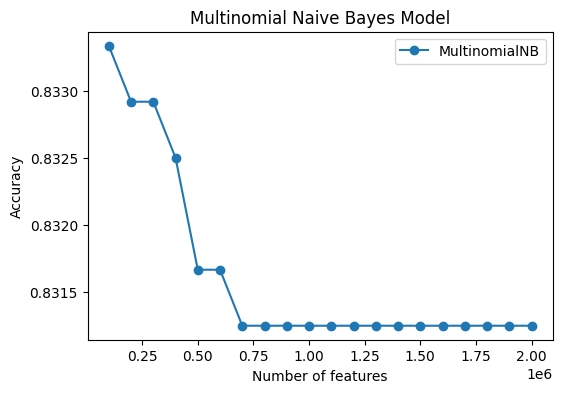

In [52]:
mnb_accu = pd.DataFrame(mnb_tfidf_accuracies, columns=['topwords', 'accuracy'])

# Create the figure for the plot with smaller size
fig = plt.figure(figsize=(6, 4))  # Adjusted figure size to make it smaller

# Plot the accuracies against the number of features
plt.plot(mnb_accu.topwords, mnb_accu.accuracy, label='MultinomialNB', marker='o')

# Optional: Add legend
plt.legend()

# Set labels and title
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Multinomial Naive Bayes Model")

# Save the figure with a smaller size
fig.savefig("model_mnb_large_100k.png", dpi=300)  # You can adjust dpi for quality

# Show the plot (optional, for interactive environments)
plt.show()

In [53]:
mnb_accu[mnb_accu.accuracy==max(mnb_accu.accuracy)]

,topwords,accuracy
0,100000,0.833333


In [54]:
best_n_topwords_mnb = mnb_accu[mnb_accu.accuracy==max(mnb_accu.accuracy)].iloc[0,0]
best_n_topwords_mnb

100000

In [55]:
# Logistic
possible_n = [100000 * i for i in range(1, 21)]

lgr_tfidf_accuracies = []

for i, n in enumerate(possible_n):
    metr = train_with_n_topwords(n, model_name="LogisticRegression")[0]
    lgr_tfidf_accuracies.append([n, metr])

N of topwords: 100000 alpha: 1.0 accuracy: 0.82
N of topwords: 200000 alpha: 1.0 accuracy: 0.8183333333333334
N of topwords: 300000 alpha: 1.0 accuracy: 0.8183333333333334
N of topwords: 400000 alpha: 1.0 accuracy: 0.8166666666666667
N of topwords: 500000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 600000 alpha: 1.0 accuracy: 0.81625
N of topwords: 700000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 800000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 900000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1000000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1100000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1200000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1300000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1400000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1500000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1600000 alpha: 1.0 accuracy: 0.8170833333333334
N of topwords: 1700000 alp

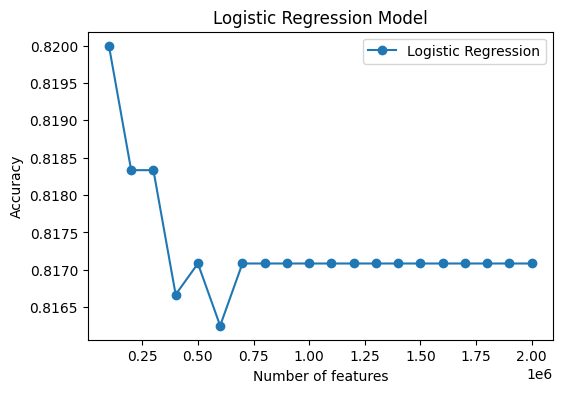

In [56]:
lgr_accu = pd.DataFrame(lgr_tfidf_accuracies, columns=['topwords', 'accuracy'])


fig = plt.figure(figsize=(6, 4))

plt.plot(lgr_accu.topwords, lgr_accu.accuracy, label='Logistic Regression', marker='o')

plt.legend()


plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Model")

fig.savefig("model_lgr_large_100k.png", dpi=150)


plt.show()

In [57]:
lgr_accu[lgr_accu.accuracy==max(lgr_accu.accuracy)]

,topwords,accuracy
0,100000,0.82


In [58]:
best_n_topwords_lgr = lgr_accu[lgr_accu.accuracy==max(lgr_accu.accuracy)].iloc[0,0]
best_n_topwords_lgr

100000

In [59]:
# Linear SVC
possible_n = [100000 * i for i in range(1, 21)]

svc_tfidf_accuracies = []

for i, n in enumerate(possible_n):
    metr = train_with_n_topwords(n, model_name="LinearSVC")[0]
    svc_tfidf_accuracies.append([n, metr])

N of topwords: 100000 alpha: 1.0 accuracy: 0.8433333333333334
N of topwords: 200000 alpha: 1.0 accuracy: 0.84375
N of topwords: 300000 alpha: 1.0 accuracy: 0.8433333333333334
N of topwords: 400000 alpha: 1.0 accuracy: 0.8408333333333333
N of topwords: 500000 alpha: 1.0 accuracy: 0.8416666666666667
N of topwords: 600000 alpha: 1.0 accuracy: 0.84
N of topwords: 700000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 800000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 900000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1000000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1100000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1200000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1300000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1400000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1500000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1600000 alpha: 1.0 accuracy: 0.8395833333333333
N of topwords: 1700000 alp

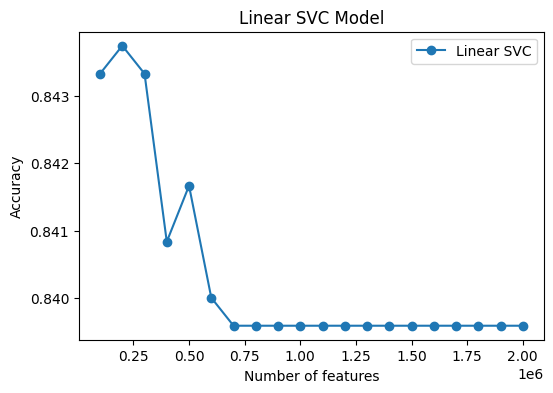

In [60]:
svc_accu = pd.DataFrame(svc_tfidf_accuracies, columns=['topwords', 'accuracy'])
fig = plt.figure(figsize=(6, 4))
plt.plot(svc_accu.topwords, svc_accu.accuracy, label='Linear SVC', marker='o')
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Linear SVC Model")
fig.savefig("model_svc_large_100k.png", dpi=150)
plt.show()

In [61]:
svc_accu[svc_accu.accuracy==max(svc_accu.accuracy)]

,topwords,accuracy
1,200000,0.84375


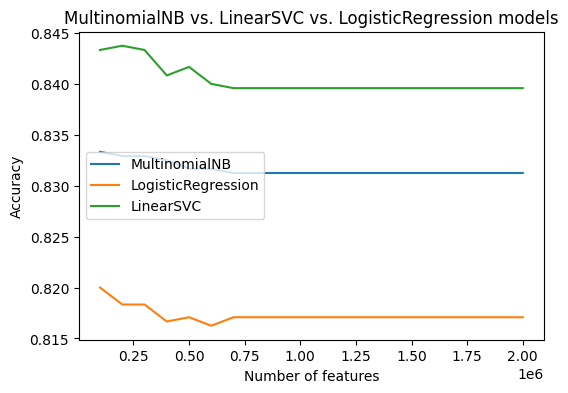

In [62]:
#Summary of three model
fig = plt.figure(figsize=(6,4))
plt.plot(mnb_accu.topwords, mnb_accu.accuracy, label='MultinomialNB')
plt.plot(lgr_accu.topwords, lgr_accu.accuracy, label='LogisticRegression')
plt.plot(svc_accu.topwords, svc_accu.accuracy, label='LinearSVC')
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("MultinomialNB vs. LinearSVC vs. LogisticRegression models")
fig.savefig("model_all3_large_100k.png")

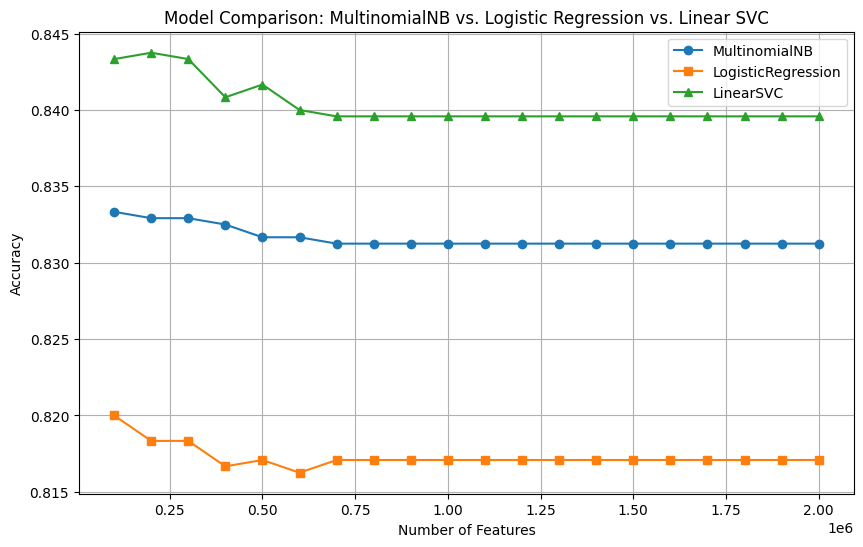

In [64]:
import matplotlib.pyplot as plt

# Create the figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data for each model
ax.plot(mnb_accu.topwords, mnb_accu.accuracy, label='MultinomialNB', marker='o')
ax.plot(lgr_accu.topwords, lgr_accu.accuracy, label='LogisticRegression', marker='s')
ax.plot(svc_accu.topwords, svc_accu.accuracy, label='LinearSVC', marker='^')

# Customize the plot
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Model Comparison: MultinomialNB vs. Logistic Regression vs. Linear SVC")
ax.legend()
ax.grid(True)  # Add a grid for better readability

# Show the plot
plt.show()

Index(['pos_neg', 'reviewText'], dtype='object')


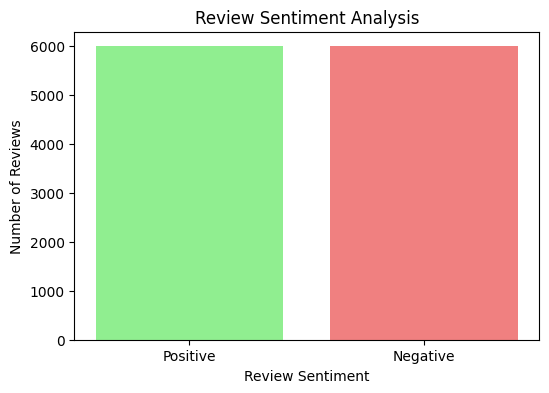

In [63]:
print(df.columns)

# Calculate the number of positive and negative reviews
pos_reviews = len(df[df['pos_neg'] == 'pos'])
neg_reviews = len(df[df['pos_neg'] == 'neg'])

# Create a bar chart to visualize the review sentiment
labels = ['Positive', 'Negative']
values = [pos_reviews, neg_reviews]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, values, color=['lightgreen', 'lightcoral'])
ax.set_xlabel('Review Sentiment')
ax.set_ylabel('Number of Reviews')
ax.set_title('Review Sentiment Analysis')
plt.show()

In [67]:
import pandas as pd

# Create a list of lists to represent the table data
table_data = [
    ["Step", "Description", "Code Snippet", "Model Relevance"],
    [
        "1. Data Loading and Preprocessing",
        "- Loads data from a CSV file.\n- Creates a sentiment label ('pos_neg').\n- Preprocesses text (negation handling, stop word removal, lemmatization, n-grams).",
        "data = pd.read_csv('/content/preprocessed_kindle_review .csv')\ndata.loc[data['rating'].isin([1,2,3]), 'pos_neg'] = 'neg'\ndef preprocessing(line, ngram=1, neg_handling=True, remove_stop=False):",
        "All Models: Preprocessed data is essential for all three models to extract meaningful features."
    ],
    [
        "2. Data Splitting",
        "- Divides data into training, validation, and testing sets.",
        "train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=1234)",
        "All Models: Splitting data ensures model evaluation on unseen data and prevents overfitting."
    ],
    [
        "3. Feature Extraction",
        "- Creates a vocabulary of frequent words (features).\n- Converts text into numerical representations using TF-IDF.",
        "word_features = nltk.FreqDist(tokens)\ntf_vec = TfidfVectorizer()\ntrain_features = tf_vec.transform(train_data)",
        "All Models: Feature extraction transforms text into a format suitable for machine learning algorithms."
    ],
    [
        "4. Model Training and Evaluation",
        "- Multinomial Naive Bayes: Trains a probabilistic model based on word frequencies.\n- Logistic Regression: Trains a model to predict the probability of a sentiment.\n- Linear SVC: Trains a model to find the optimal hyperplane separating sentiments.",
        "mnb_model = MultinomialNB()\nmnb_model.fit(train_features, train_labels)\nlgr_model = LogisticRegression()\nlgr_model.fit(train_features, train_labels)\nsvc_model = LinearSVC()\nsvc_model.fit(train_features, train_labels)",
        "Model Specific: Each model uses a different algorithm to learn from the data and make predictions."
    ],
    [
        "5. Hyperparameter Tuning",
        "- Optimizes model performance by adjusting parameters (e.g., number of features, regularization).",
        "def train_with_n_topwords(n, model_name='MultinomialNB', tfidf=True, valid=True, alpha=1.0):",
        "All Models: Tuning helps find the best configuration for each model to achieve higher accuracy."
    ],
    [
        "6. Model Comparison",
        "- Visualizes the accuracy of different models with varying numbers of features.",
        "plt.plot(mnb_accu.topwords, mnb_accu.accuracy, label='MultinomialNB')\nplt.plot(lgr_accu.topwords, lgr_accu.accuracy, label='LogisticRegression')\nplt.plot(svc_accu.topwords, svc_accu.accuracy, label='LinearSVC')",
        "All Models: Comparing performance helps select the most effective model for the task."
    ]
]

# Create a Pandas DataFrame from the table data
df = pd.DataFrame(table_data[1:], columns=table_data[0])

# Display the DataFrame as a formatted table
display(df)

,Step,Description,Code Snippet,Model Relevance
0,1. Data Loading and Preprocessing,- Loads data from a CSV file.\n- Creates a sen...,data = pd.read_csv('/content/preprocessed_kind...,All Models: Preprocessed data is essential for...
1,2. Data Splitting,"- Divides data into training, validation, and ...","train_test_split(data, labels, test_size=0.4, ...",All Models: Splitting data ensures model evalu...
2,3. Feature Extraction,- Creates a vocabulary of frequent words (feat...,word_features = nltk.FreqDist(tokens)\ntf_vec ...,All Models: Feature extraction transforms text...
3,4. Model Training and Evaluation,- Multinomial Naive Bayes: Trains a probabilis...,mnb_model = MultinomialNB()\nmnb_model.fit(tra...,Model Specific: Each model uses a different al...
4,5. Hyperparameter Tuning,- Optimizes model performance by adjusting par...,"def train_with_n_topwords(n, model_name='Multi...",All Models: Tuning helps find the best configu...
5,6. Model Comparison,- Visualizes the accuracy of different models ...,"plt.plot(mnb_accu.topwords, mnb_accu.accuracy,...",All Models: Comparing performance helps select...


In [73]:
from sklearn.metrics import accuracy_score

# Assuming you have already trained the models and made predictions:
# mnb_model, lgr_model, svc_model
# pred (for MultinomialNB), lgr_pred, svc_pred

# Calculate accuracy for each model
mnb_accuracy = accuracy_score(test_labels, pred)
lgr_accuracy = accuracy_score(test_labels, lgr_pred)
svc_accuracy = accuracy_score(test_labels, svc_pred)

# Print the accuracies
print("Multinomial Naive Bayes Accuracy:", mnb_accuracy)
print("Logistic Regression Accuracy:", lgr_accuracy)
print("Linear SVC Accuracy:", svc_accuracy)

Multinomial Naive Bayes Accuracy: 0.8304166666666667
Logistic Regression Accuracy: 0.82
Linear SVC Accuracy: 0.8454166666666667


##Conclusion
####The code compares three text classification models (Multinomial Naive Bayes, Logistic Regression, and Linear SVC) for sentiment analysis of Kindle reviews. By analyzing their performance with varying features, the code aims to identify the best-performing model and optimal feature set.
####In conclusion, the code helps determine the most effective approach for classifying Kindle review sentiment, considering accuracy and model complexity. It also provides insights into the overall sentiment expressed in the dataset.
####Since Linear SVC achieves the highest accuracy, the conclusion states that it's the most suitable model, using a specific number of features for optimal performance. It would also highlight the general sentiment (positive as well as negative) prevalent in the reviews.